<h2>BMIF201 Lecture 5 in-class problem set instructions</h2>

This problem set investigates the ways in which selection interacts with linkage. 

<h5> Problem 1 </h5>

Write a Wright-Fisher simulator with two partially linked loci and many possible alleles at each locus. To do this, you will need to simulate individual haplotypes instead of just allele frequencies. Use the template provided.
 

In [ ]:
import numpy as np

class WFTwoLoci:
    haplotypes: np.ndarray # size (2N, num_sites)
    fitness: np.ndarray # size 2N
    s: list[float] # length num_sites
    mu: list[float] # length num_sites\
    allele_counter: int 
    
    def __init__(self, N: int, s: list[float], mu: list[float]):
        self.s = s
        self.mu = mu
        self.haplotypes = np.zeros((2*N, self.num_sites), dtype=np.int64)
        self.fitness = np.ones(2*N, dtype=np.float64) / (2*N)
        self.allele_counter = 0
    
    @property
    def num_sites(self) -> int:
        return len(self.s)
    
    @property
    def N(self) -> int:
        return len(self.haplotypes) // 2
    
    def add_mutations_at_site(self, site: int):
        num_mutations = np.random.binomial(n=2*self.N, p=self.mu[site])
        for _ in range(num_mutations):
            mutant = np.random.randint(2*self.N)
            self.haplotypes[mutant, site] = self.allele_counter
            self.allele_counter += 1
            self.fitness[mutant] *= 1 + self.s[site]
        self.fitness = self.fitness / np.sum(self.fitness)

    def next_generation(self):
        parents = np.random.choice(np.arange(2*self.N), 
                                    size=2*self.N,
                                    p=self.fitness,
                                    replace=True)
        self.haplotypes = self.haplotypes[parents]
        self.fitness = self.fitness[parents]
        for site in range(self.num_sites):
            self.add_mutations_at_site(site)
    
    def heterozygosity_at_site(self, site: int) -> float:
        _, counts = np.unique(self.haplotypes[:, site], return_counts=True)
        frequencies = counts / (2*self.N)
        return 1 - np.sum(frequencies**2)
        

<h5>Problem 2</h5>

Simulate background selection in a model with two sites, where one of the sites has a high mutation rate and a negative selection coefficient and the other has a low mutation rate and a selection coefficient of zero. Compute the average heterozygosity of the neutral site, with and without background selection. What do you observe? Vary the selection coefficient of the selected site; is there a monotonic relationship? Discuss with your partner.

In [ ]:
N=100
mu_neutral=.001
mu_nonneutral=0.1
s_vals = [0, -0.001, -0.01, -0.1, -.9]
generations=100*N
linked_het = []
print(f"4Nmu/(1+4Nmu): {4*N*mu_neutral/(1+4*N*mu_neutral)}")

for s in s_vals:
    model = WFTwoLoci(N=N, s=[0,s], mu=[mu_neutral, mu_nonneutral])
    
        
    for i in range(N): # burn-in
        model.next_generation()
        
    het = 0
    for i in range(generations):
        model.next_generation()
        het += model.heterozygosity_at_site(0)
    
    het /= generations
    linked_het.append(het)
    print(f"s={s}: het={het}")


4Nmu/(1+4Nmu): 0.28571428571428575
s=0: het=0.2636638949999997
s=-0.001: het=0.29069494999999845
s=-0.01: het=0.21908217000000055
s=-0.1: het=0.1403115399999942
s=-0.9: het=0.2568841750000044


<h5>Problem 3</h5>

To see the effect of selective sweeps, compare a simulation with s=0 vs. one with s>0, and plot the heterozygosity over time. Simulate a low mutation rate for the positively selected locus; you should be able to see abrupt dips in heterozygosity at the time of each sweep.

In [ ]:
N=1000
mu_neutral=.001
mu_nonneutral=0.005 / N
s=.1
generations=5*N
neutral_model = WFTwoLoci(N=N, s=[0,0], mu=[mu_neutral, mu_nonneutral])
nonneutral_model = WFTwoLoci(N=N, s=[0,s], mu=[mu_neutral, mu_nonneutral])

neutral_het = np.zeros(generations)
for i in range(generations):
    neutral_model.next_generation()
    neutral_het[i] = neutral_model.heterozygosity_at_site(0)
print(f"Neutral site: {np.mean(neutral_het[N:])}")

linked_het = np.zeros(generations)
nonneutral_het = np.zeros(generations)
for i in range(generations):
    nonneutral_model.next_generation()
    linked_het[i] = nonneutral_model.heterozygosity_at_site(0)
    nonneutral_het[i] = nonneutral_model.heterozygosity_at_site(1)

print(f"Selected site: {np.mean(nonneutral_het[N:])}")
print(f"Linked site: {np.mean(linked_het[N:])}")


Neutral site: 0.740750005
Selected site: 0.034077659749999996
Linked site: 0.49807340249999993


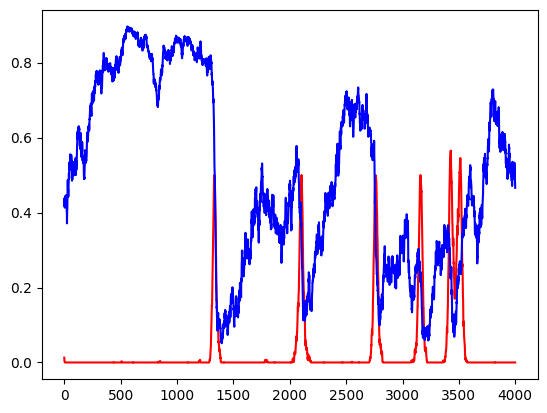

In [43]:
import matplotlib.pyplot as plt
plt.plot(nonneutral_het[N:], color='red', label='Selected site')
plt.plot(linked_het[N:], color='blue', label='Linked site')

<h5>Problem 4</h5>

Discuss with your partner: suppose you were given sequencing data for a locus that had putatively undergone a recent selective sweep. How would you distinguish this hypothesis from the hypothesis that this locus was neutral? How would you distinguish it from the hypothesis that the locus was subject to background selection?